In [1]:
!pip install google-search-results
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for google-search-results: filename=google_search_results-2.4.2-py3-none-any.whl size=32019 sha256=6a4afbb633d51f2a50362a77ee1caf172b27530cd97b731bccdcc86293f9ff30
  Stored in directory: /root/.cache/pip/wheels/d3/b2/c3/03302d12bb44a2cdff3c9371f31b72c0c4e84b8d2285eeac53
Successfully built google-search-results
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.6 MB/s eta 0:00:00


In [2]:
import dask.dataframe as dd
from serpapi import GoogleSearch
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller as ADF


import json
import pandas as pd
import seaborn as sns
import dask.dataframe as dd
import matplotlib.pyplot as plt

In [3]:
def fetch_data(topic):
    # paremetners for SERP API 
    params = {
        "engine": "google_trends",
        "q": topic,
        "data_type": "TIMESERIES",
        "date": "all",
        "api_key": "a6089e527a003d73adcb30646872ead71c83df40135fb2dd19848fa1c1d12644"
    }

    # fetching the interest over time for a given topic
    search = GoogleSearch(params)
    results = search.get_dict()
    interest_over_time = results["interest_over_time"]

    return interest_over_time

In [4]:
def extract_data_from_json(json_file, read_file_from_path):
    fetched_json_file = json_file

    if read_file_from_path:
        # if the read_file_from_path is True, read the file from the given path
        # and parse it as JSON
        with open(json_file, 'r') as file:
            fetched_json_file = json.load(file)

    # Define the column names for the dataframe
    columns = ["Topic", "Time", "Frequency"]

    # Initialize an empty list to store the cleaned data
    cleaned_data = []

    # Extract the raw data from the JSON file
    raw_data = fetched_json_file['timeline_data']

    # Loop through each record in the raw data and extract the relevant fields
    for record in raw_data:
        cleaned_data.append(
            [
                    record["values"][0]["query"],  # Extract the topic
                    record["date"].replace("\u2009", " "),  # Extract the time
                    record["values"][0]["extracted_value"]  # Extract the frequency
            ]
        )

    # Create a pandas dataframe from the cleaned data and column names
    df = pd.DataFrame(cleaned_data, columns=columns)

    # Return the resulting dataframe
    return df


In [5]:
def preprocess(data):
    # Change the date(str) to datetime using Dask's to_datetime function
    data['Date'] = dd.to_datetime(data['Time'])

    # Change the index into datetime using set_index method
    data = data.set_index('Date')
    frequencies = data[['Frequency']]

    return frequencies

In [6]:
def draw_ADF(df):
  # Calculate the first and second differences of the 'Frequency' column and add them to the dataframe
  df['diff_1'] = df['Frequency'].diff(1)
  df['diff_2'] = df['diff_1'].diff(1)

  # Replace missing values in the differences with 0
  df['diff_1'] = df['diff_1'].fillna(0)
  df['diff_2'] = df['diff_2'].fillna(0)

  # Calculate the Augmented Dickey-Fuller (ADF) test statistics for the 'Frequency' column and its differences
  adf = ADF(df['Frequency'].to_dask_array(lengths=True))
  diff1_adf = ADF(df['diff_1'].to_dask_array(lengths=True))
  diff2_adf = ADF(df['diff_2'].to_dask_array(lengths=True))

  # Print the ADF test statistics for the 'Frequency' column and its differences
  print('timeseries adf:', adf)
  print('timeseries diff_1 adf:', diff1_adf)
  print('timeseries diff_2 adf:', diff2_adf)

  # Plot the dataframe as subplots
  df.compute().plot(subplots=True, figsize=(15,12))

  # Remove the 'diff_1' and 'diff_2' columns from the dataframe
  df = df.drop(labels=['diff_2'], axis=1)
  df = df.drop(labels=['diff_1'], axis=1)
  
  # Return the dataframe without the 'diff_1' and 'diff_2' columns
  return df

In [7]:
def apply_ARIMA(data, start, end, date_range):
  # Set the training data to the input 'data'
  train = data
  
  # Fit an ARIMA model to the training data using the auto_arima function
  arima_model = auto_arima(train, start_p=0, d=1, start_q=0,
                         max_p=5, max_d=5, max_q=5, start_P=0, 
                         D=1, start_Q=0, max_P=5,max_D=5, 
                         max_Q=5, m=12, seasonal=True, 
                         error_action='warn', trace=True, 
                         supress_warnings=True, stepwise=True, 
                         random_state=20,n_fits=50)
  
  # Generate predictions for the specified time range using the fitted ARIMA model
  predictions = pd.DataFrame(arima_model.predict(start=start,end=end,n_periods=12),index=date_range)
  predictions.columns = ["Frequencies"]
  
  # Return the predicted frequencies as a dataframe
  return predictions

In [8]:
def predict_data(data):
  # Convert the input data to a Dask dataframe with 10 partitions
  data = dd.from_pandas(data, npartitions=10)
  print("Step 1: Converting to Dask Dataframe, Done")

  # Preprocess the data
  processed_data = preprocess(data)
  print("Step 2: Preprocessing before prediction, Done")

  # Define the start and end dates for the prediction period
  start = processed_data.compute().index[-1] + pd.offsets.MonthBegin(1)
  end = processed_data.compute().index.values[-1] + pd.offsets.MonthBegin(12)
  date_range = pd.date_range(start=start, end=end, freq="MS")

  # Generate predictions for the specified time range using the apply_ARIMA function
  predictions = apply_ARIMA(processed_data.compute(), start, end, date_range)
  print("Step 4: Predicting best fit using AIRMA models, Done")

  # Reformat the predicted frequencies as a dataframe
  predictions = pd.DataFrame({
    "Topic":[topic]*12, 
    "Time":predictions.index.tolist(), 
    "Record Type":["predictions"]*12,
    "Frequency":predictions["Frequencies"].tolist()
     })
  print("Step 5: Reformatting predictions according to DB requirements, Done")

  # Reformat the input data according to DB requirements
  data = data.drop('Time', axis=1)
  data = pd.DataFrame(data.compute())
  data["Record Type"] = ["data"]*len(data)
  data = data.rename(columns={'Date': 'Time'})
  data = data.reindex(columns=['Topic', 'Time', 'Record Type', 'Frequency'])
  print("Step 6: Reformatting historical data according to DB requirements, Done")

  # Concatenate the historical data with the predictions
  resampled_df = pd.concat([data, predictions])
  resampled_df = resampled_df.reset_index(drop=True)  
  print("Step 7: Concatinating historical data with predictions, Done")

  # Convert the resulting dataframe back to a Dask dataframe with 10 partitions 
  # and convert the 'Frequency' column to integers
  resampled_df = dd.from_pandas(resampled_df, npartitions=10)
  resampled_df['Frequency'] = resampled_df['Frequency'].astype(int)
  print("Step 8: converting frequencies to 'int', Done")
  
  # Compute and return the resulting dataframe
  return resampled_df.compute()


In [9]:
# topic = 'Air conditioner'.lower()
# topic = 'Oven'.lower()
# topic = 'DSLR'.lower()
# topic = 'Desktop'.lower()
# topic = 'Washing Machines'.lower()

topic = 'ipad'.lower()
data_json = fetch_data(topic)

In [10]:
# fetching data from json as a dataframe
data = extract_data_from_json(data_json, read_file_from_path=False)

# predicting the frequencies for 1 year
resampled_df = predict_data(data)

Step 1: Converting to Dask Dataframe, Done
Step 2: Preprocessing before prediction, Done
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1452.346, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1418.586, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.52 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1432.885, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1400.455, Time=0.51 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1395.747, Time=0.94 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=1390.324, Time=1.85 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=1387.691, Time=4.65 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=20.03 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=14.63 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=1401.813, Time=3.76 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=1376.674, Time=4.25 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=1379.337, Time=2.18 sec
 ARIMA(2,1

In [11]:
# fetching historical and predictied data
historical_data = resampled_df[resampled_df["Record Type"] == 'data']
predicted_data = resampled_df[resampled_df["Record Type"] == 'predictions']

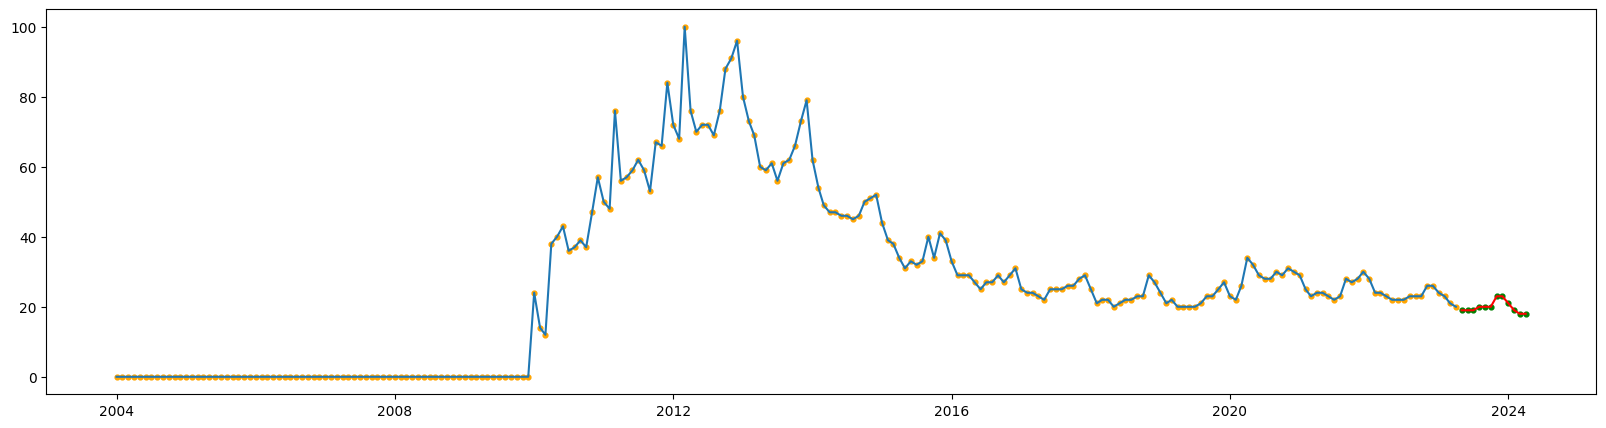

In [12]:
# plotting them
fig = plt.figure(figsize=(20, 5))

plt.plot(historical_data.Time, historical_data.Frequency)
plt.scatter(historical_data.Time, historical_data.Frequency, c="Orange", s=12)

plt.plot(predicted_data.Time, predicted_data.Frequency, c="Red")
plt.scatter(predicted_data.Time, predicted_data.Frequency, c="Green", s=12)

plt.show()